In [1]:
import os
import urllib.request
import tarfile
from shutil import copyfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder

from torch.utils import model_zoo

from poutyne.framework import Model, ModelCheckpoint, BestModelRestore, CSVLogger, Experiment
from poutyne import torch_to_numpy, set_seeds

In [2]:
data_dir = "./data/bananas"

In [3]:
# [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

num_classes = 2
batch_size = 16
n_epoch = 20
feature_extract = True
learning_rate = 0.01
weight_decay = 0.001
momentum = 0.9

In [4]:
set_seeds(42)

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [6]:
base_path = data_dir
dataset_path = os.path.join(base_path, 'images')
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962,  0.4914721 ,  0.42382449), (0.22846779,  0.22387765,  0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_coefs['cub200'])
])

train_set = ImageFolder(train_path, transform=transform)
valid_set = ImageFolder(valid_path, transform=transform)
test_set = ImageFolder(test_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
loss_function = nn.CrossEntropyLoss()

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [8]:
callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint('last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),
    
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint('best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),
    
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger('log.tsv', separator='\t'),
]

In [9]:
model = Model(model_ft, optimizer, loss_function, batch_metrics=['accuracy'], epoch_metrics=['f1'])

# Send model on GPU
model.to(device)

# Train
model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Epoch 1/20 13.72s Step 59/59: loss: 0.260586, acc: 89.574468, fscore_micro: 0.895745, val_loss: 0.140181, val_acc: 94.964029, val_fscore_micro: 0.949640
Epoch 1: val_acc improved from -inf to 94.96403, saving file to best_epoch_1.ckpt
Epoch 2/20 14.19s Step 59/59: loss: 0.088383, acc: 96.702128, fscore_micro: 0.967021, val_loss: 0.132063, val_acc: 95.503597, val_fscore_micro: 0.955036
Epoch 2: val_acc improved from 94.96403 to 95.50360, saving file to best_epoch_2.ckpt
Epoch 3/20 13.23s Step 59/59: loss: 0.054763, acc: 97.872340, fscore_micro: 0.978723, val_loss: 0.138015, val_acc: 94.964029, val_fscore_micro: 0.949640
Epoch 4/20 13.27s Step 59/59: loss: 0.031255, acc: 98.936170, fscore_micro: 0.989362, val_loss: 0.145809, val_acc: 95.323741, val_fscore_micro: 0.953237
Epoch 5/20 13.48s Step 59/59: loss: 0.027243, acc: 98.829787, fscore_micro: 0.988298, val_loss: 0.188951, val_acc: 95.143885, val_fscore_micro: 0.951439
Epoch 6/20 13.43s Step 59/59: loss: 0.019704, acc: 99.148936, fscor

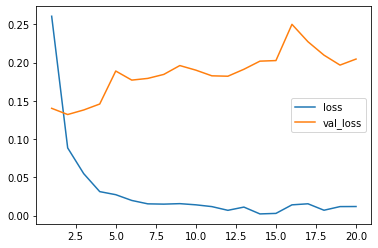

In [10]:
logs = pd.read_csv('log.tsv', sep='\t')
best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])

metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

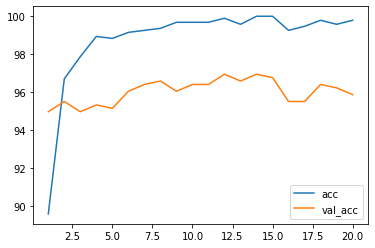

In [11]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


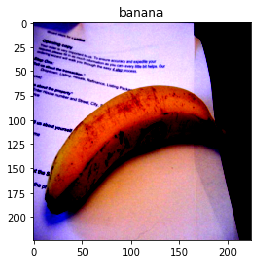

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


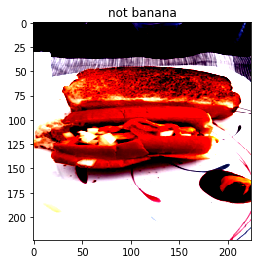

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


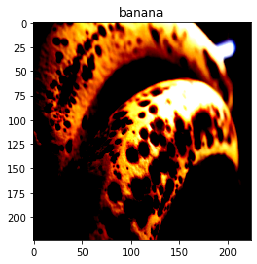

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


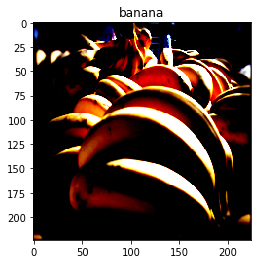

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


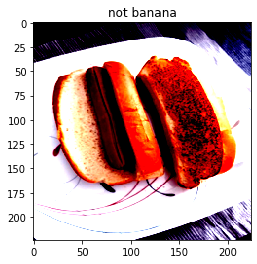

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


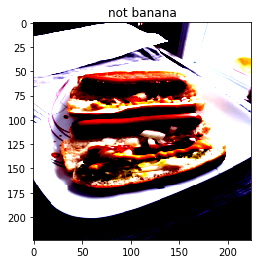

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


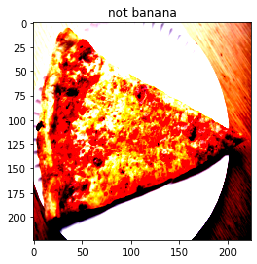

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


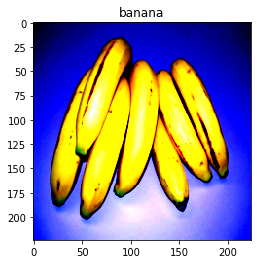

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


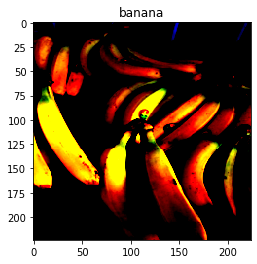

In [12]:
curtom_set = ImageFolder(data_dir + '/custom', transform=transform)
custom_loader = torch.utils.data.DataLoader(curtom_set, batch_size=1, shuffle=True)

for i, (x, y) in enumerate(custom_loader):
    out = model.predict(x)
    prediction = ('' if np.argmax(out, axis=1)[0] == 0 else 'not ') + 'banana'
    img = x[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(prediction)
    plt.show()